<a href="https://colab.research.google.com/github/heyitzrizki/final-project-ds49-group3/blob/main/modeling/Model_Development_no_outlier_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0.1 Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Train test dan Hyperparameter Tuning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, fbeta_score, roc_auc_score, roc_curve,
    classification_report, confusion_matrix
)
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import sklearn

warnings.filterwarnings("ignore")

# 0.2 Load Dataset

In [2]:
url = 'https://raw.githubusercontent.com/heyitzrizki/final-project-ds49-group3/refs/heads/main/data/df_no_outlier_all_encoded.csv'
df = pd.read_csv(url)
df.head()

,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,...,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown
0,4,3441,4,557.0,1239.0,33,14,21,62,682,...,False,False,False,False,False,False,False,False,False,False
1,1,1900,1,1400.0,1400.0,1,2,2,67,0,...,False,False,False,True,False,False,False,False,False,False
2,1,1900,1,1900.0,1900.0,1,0,0,29,0,...,False,False,False,False,False,False,False,False,False,False
3,3,3900,3,1100.0,1600.0,6,6,9,39,500,...,False,False,False,False,False,False,False,False,False,False
4,3,5000,3,1500.0,1900.0,2,2,2,38,400,...,False,False,False,False,False,False,False,False,False,False


# Log Data Skewed

## 1.1 Verify Numerical Columns Skewness

In [3]:
# y = df['subtotal']
# y_log = np.log1p(y)

# skewed_features = ['total_items', 'subtotal', 'num_distinct_items',
#                       'min_item_price', 'max_item_price',
#                       'total_onshift_partners', 'total_busy_partners',
#                       'total_outstanding_orders']

# X = df.drop('delivery_time', axis=1).copy()

# for col in skewed_features:
#     X[col] = np.log1p(X[col])

In [4]:
continuous_features = [
    'total_items', 'num_distinct_items',
                      'min_item_price', 'max_item_price',
                      'total_onshift_partners', 'total_busy_partners',
                      'total_outstanding_orders'
]

df_skew_verify = df.loc[:, continuous_features]

In [5]:
skew_ft = []

for i in continuous_features:
    # list of skew for each corresponding feature
    skew_ft.append(abs(df_skew_verify[i].skew()))

df_skewed = pd.DataFrame(
    {
        "Columns": continuous_features,
        "Abs_Skew": skew_ft
    }
)

sk_features = df_skewed[df_skewed["Abs_Skew"] > 0.5]["Columns"].tolist()
print("List of skewed features:\n")
print(sk_features)

List of skewed features:

['total_items', 'num_distinct_items', 'min_item_price', 'total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']


In [6]:
# loop over i (features) to calculate Log of surfaces
for i in sk_features:

    df[i] = np.log((df[i]) + 1)

Text(0, 0.5, '')

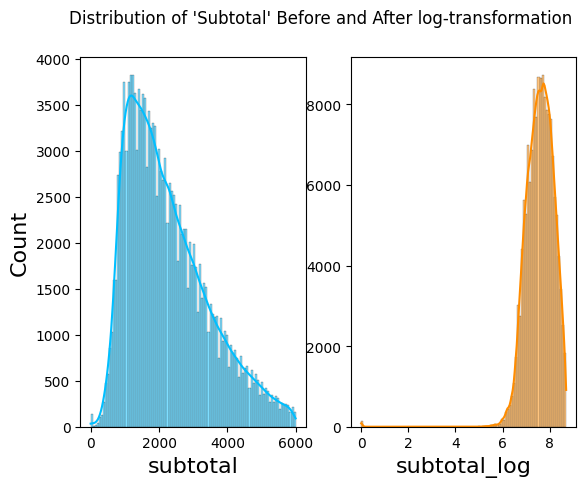

In [7]:
# Log transformation of the target variable "subtotal"
df["subtotal_log"] = np.log1p(df["subtotal"])

# Plot the distribution before and after transformation
fig, axes = plt.subplots(1, 2)
fig.suptitle("Distribution of 'Subtotal' Before and After log-transformation")
fontsize = 16

# before log transformation
p = sns.histplot(
    ax=axes[0],
    x=df["subtotal"],
    kde=True,
    bins=100,
    color="deepskyblue"
)
p.set_xlabel("subtotal", fontsize=fontsize)
p.set_ylabel("Count", fontsize=fontsize)

# after log transformation
q = sns.histplot(
    ax=axes[1],
    x=df["subtotal_log"],
    kde=True,
    bins=100,
    color="darkorange"
)

q.set_xlabel("subtotal_log", fontsize=fontsize)
q.set_ylabel("", fontsize=fontsize)

In [8]:
# Drop the original SalePrice
df.drop(
    columns=["subtotal"],
    inplace=True
)

In [9]:
df.head()

,total_items,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,store_primary_category_afghan,...,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown,subtotal_log
0,1.609438,1.609438,6.324359,1239.0,3.526361,2.708050,3.091042,62,682,False,...,False,False,False,False,False,False,False,False,False,8.143808
1,0.693147,0.693147,7.244942,1400.0,0.693147,1.098612,1.098612,67,0,False,...,False,False,True,False,False,False,False,False,False,7.550135
2,0.693147,0.693147,7.550135,1900.0,0.693147,0.000000,0.000000,29,0,False,...,False,False,False,False,False,False,False,False,False,7.550135
3,1.386294,1.386294,7.003974,1600.0,1.945910,1.945910,2.302585,39,500,False,...,False,False,False,False,False,False,False,False,False,8.268988
4,1.386294,1.386294,7.313887,1900.0,1.098612,1.098612,1.098612,38,400,False,...,False,False,False,False,False,False,False,False,False,8.517393


# Data Splitting and Standardization

#### 2.1 Splitting the Dataset into Train and Test

In [10]:
y = df["subtotal_log"] #Target
X = df.drop(columns="subtotal_log")
print(X.shape)
print(y.shape)

(150010, 88)
(150010,)


In [11]:
# Create 50 quantile bins for even distribution
bins = np.linspace(0, len(y), 150)
y_binned = np.digitize(y, bins)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y_binned,
    shuffle=True,
    random_state=42
)

print(f"X_train:{X_train.shape}\ny_train:{y_train.shape}")
print(f"\nX_test:{X_test.shape}\ny_test:{y_test.shape}")
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, stratify=y, random_state=0
# )

# #to resolve any class imbalance - use stratify parameter.

# print("Number transactions X_train dataset: ", X_train.shape)
# print("Number transactions y_train dataset: ", y_train.shape)
# print("Number transactions X_test dataset: ", X_test.shape)
# print("Number transactions y_test dataset: ", y_test.shape)

X_train:(120008, 88)
y_train:(120008,)

X_test:(30002, 88)
y_test:(30002,)


In [12]:
y_test.head()

,subtotal_log
146059,7.730175
10426,7.127694
41273,8.088255
61009,6.618739
98538,7.550135


#### 2.2 Data Standarization

In [13]:
# StandarScaler for encode data no outliers
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns, index=X_test.index)

In [14]:
X_train

,total_items,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,item_price_range,store_primary_category_afghan,...,store_primary_category_vegan,store_primary_category_vegetarian,store_primary_category_vietnamese,order_protocol_2.0,order_protocol_3.0,order_protocol_4.0,order_protocol_5.0,order_protocol_6.0,order_protocol_7.0,order_protocol_Unknown
32323,0.375451,0.636079,-0.791951,-0.160296,-0.266120,-0.089997,0.128100,-0.520867,0.855349,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,1.687058,-0.327035,-0.548710,-0.0652,-0.01,-0.072122
51768,-0.377115,-1.334161,0.745719,-0.213767,-0.720588,-0.763554,-1.028976,-0.357081,-0.998496,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,1.687058,-0.327035,-0.548710,-0.0652,-0.01,-0.072122
78774,-0.377115,-0.181644,0.448993,-0.614798,-0.651216,-0.546717,-0.509143,-0.782924,-0.811867,-0.023279,...,-0.037553,-0.06565,5.333837,-0.366852,-0.592748,-0.327035,-0.548710,-0.0652,-0.01,-0.072122
129343,-0.377115,-0.181644,-0.885971,-1.700254,-1.164848,-1.043106,-0.944685,0.330819,-0.528192,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,-0.592748,-0.327035,-0.548710,-0.0652,-0.01,-0.072122
19729,0.959186,1.270355,-0.192981,0.387779,0.791752,0.542204,0.281340,-0.324324,0.930000,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,-0.592748,-0.327035,1.822455,-0.0652,-0.01,-0.072122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100543,0.959186,0.636079,0.187246,0.641765,0.045739,0.189555,0.301215,1.935918,0.743372,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,-0.592748,-0.327035,-0.548710,-0.0652,-0.01,-0.072122
35624,1.436132,0.636079,-1.367354,-0.026619,-1.755864,-1.614281,-1.122156,0.036005,1.228606,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,-0.592748,-0.327035,-0.548710,-0.0652,-0.01,-0.072122
146299,-1.437796,-1.334161,1.270191,1.323517,0.078709,0.126840,0.103869,0.625633,-0.998496,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,-0.592748,-0.327035,-0.548710,-0.0652,-0.01,-0.072122
65507,0.375451,0.636079,0.829549,2.513242,1.150386,1.161461,1.348129,0.461847,1.353025,-0.023279,...,-0.037553,-0.06565,-0.187482,-0.366852,1.687058,-0.327035,-0.548710,-0.0652,-0.01,-0.072122


## 2.3 Backward Stepwise Regression

In [15]:
Selected_Features = []


def backward_regression(X, y, initial_list=[], threshold_in=0.01, threshold_out=0.05, verbose=True):
    """To select feature with Backward Stepwise Regression

    Args:
        X -- features values
        y -- target variable
        initial_list -- features header
        threshold_in -- pvalue threshold of features to keep
        threshold_out -- pvalue threshold of features to drop
        verbose -- true to produce lots of logging output

    Returns:
        list of selected features for modeling
    """
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()  # null if pvalues is empty
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature: {worst_feature}, {worst_pval}")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")


# Application of the backward regression function on our training data
backward_regression(X_train, y_train)

worst_feature: store_primary_category_cajun, 0.9634226569035862
worst_feature: store_primary_category_korean, 0.95017535547619
worst_feature: store_primary_category_german, 0.9232205819111302
worst_feature: store_primary_category_spanish, 0.9053353796943098
worst_feature: order_protocol_Unknown, 0.8262379533304687
worst_feature: store_primary_category_russian, 0.7947769542036216
worst_feature: store_primary_category_lebanese, 0.7818050198244364
worst_feature: store_primary_category_singaporean, 0.7779171145371544
worst_feature: store_primary_category_alcohol, 0.7563706046462494
worst_feature: store_primary_category_belgian, 0.7194536890890636
worst_feature: store_primary_category_hawaiian, 0.7077902964232747
worst_feature: total_onshift_partners, 0.6712257886392117
worst_feature: store_primary_category_french, 0.5383135287256222
worst_feature: store_primary_category_european, 0.5119164388191105
worst_feature: store_primary_category_african, 0.47788687141853836
worst_feature: store_prim

In [16]:
# Keep the selected features only
X_train = X_train.loc[:, Selected_Features[0]]
X_test = X_test.loc[:, Selected_Features[0]]

## 2.4 Variance Inflation Factor

In [17]:
# Here we calculate VIF for each feature
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    X_train.values, i) for i in range(X_train.shape[1])]

# VIF results in a table
vif["features"] = X_train.columns
vif.round(1)

,VIF Factor,features
0,5.6,total_items
1,6.1,num_distinct_items
2,3.4,min_item_price
3,3.5,max_item_price
4,1.1,total_outstanding_orders
5,1.0,delivery_time
6,5.0,item_price_range
7,1.0,store_primary_category_afghan
8,NaN,store_primary_category_alcohol-plus-food
9,1.4,store_primary_category_american


In [18]:
# Select features with high VIF
high_vif_list = vif[(vif["VIF Factor"] > 10) | (vif["VIF Factor"].isna())]["features"].tolist()

if len(high_vif_list) == 0:
    # print empty list if low multicolinearity
    print(f"None of the features have a high multicollinearity")
else:
    # print list of features with high multicolinearity
    print(f"List of features with high multicollinearity: {high_vif_list}")

List of features with high multicollinearity: ['store_primary_category_alcohol-plus-food']


In [19]:
# Drop features with high multicollinearity from X_train, X_test
X_train.drop(high_vif_list, axis=1, inplace=True)

X_test.drop(high_vif_list, axis=1, inplace=True)

## 2.5 Cook Distance

In [20]:
X_constant = sm.add_constant(X_train)

model = sm.OLS(y_train, X_constant)
lr = model.fit()

# Cook distance
np.set_printoptions(suppress=True)

# Create an instance of influence
influence = lr.get_influence()

# Get Cook's distance for each observation
cooks = influence.cooks_distance

# Result as a dataframe
cook_df = pd.DataFrame(
    {
        "Cook_Distance": cooks[0],
        "p_value": cooks[1]
    }
)

cook_df.head()

,Cook_Distance,p_value
0,1.173908e-07,1.0
1,2.593870e-06,1.0
2,9.891750e-09,1.0
3,6.380823e-06,1.0
4,1.006015e-06,1.0


In [21]:
# Remove the influential observation from X_train and y_train
influent_observation = cook_df[cook_df["p_value"] < 0.05].index.tolist()
print(f"Influential observations dropped: {influent_observation}")

# Drop these obsrevations
X_train = X_train.drop(X_train.index[influent_observation])
y_train = y_train.drop(y_train.index[influent_observation])

Influential observations dropped: []


# Modelling

## 3.1 Models and Metrics Selection

In [22]:
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import HuberRegressor, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [23]:
# Let's define a function for each metrics
# R²
def rsqr_score(test, pred):
    """Calculate R squared score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        R squared score
    """
    r2_ = r2_score(test, pred)
    return r2_


# RMSE
def rmse_score(test, pred):
    """Calculate Root Mean Square Error score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        Root Mean Square Error score
    """
    rmse_ = np.sqrt(mean_squared_error(test, pred))
    return rmse_


# Print the scores
def print_score(test, pred):
    """Print calculated score

    Args:
        test -- test data
        pred -- predicted data

    Returns:
        print the regressor name
        print the R squared score
        print Root Mean Square Error score
    """

    print(f"- Regressor: {regr.__class__.__name__}")
    print(f"R²: {rsqr_score(test, pred)}")
    print(f"RMSE: {rmse_score(test, pred)}\n")

In [24]:
# Define regression models
dtr =  DecisionTreeRegressor()
huber = HuberRegressor(epsilon=1.35)  # robust against outliers
# quantile = QuantileRegressor(quantile=0.5, alpha=0.001, solver='highs')  # median regression
rdf = RandomForestRegressor()
xgboost = XGBRegressor()
lgbm = LGBMRegressor()

# Train models on X_train and y_train
for regr in [dtr, huber, rdf, xgboost, lgbm]:
    # fit the corresponding model
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    # Print the defined metrics above for each classifier
    print_score(y_test, y_pred)

- Regressor: DecisionTreeRegressor
R²: 0.5066041748706738
RMSE: 0.4241795950746517

- Regressor: HuberRegressor
R²: 0.7101732358553742
RMSE: 0.3251032282428171

- Regressor: RandomForestRegressor
R²: 0.7292018250516185
RMSE: 0.31424972371853926

- Regressor: XGBRegressor
R²: 0.7486672006937771
RMSE: 0.3027447510789969

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 120008, number of used features: 51
[LightGBM] [Info] Start training from score 7.576546
- Regressor: LGBMRegressor
R²: 0.7549007112198234
RMSE: 0.2989668692041055



#### a. XGBoost

In [25]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters
tuned_parameters = {
    "max_depth": [3],
    "colsample_bytree": [0.3, 0.7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 500]
}

# GridSearch
xgbr_cv = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid=tuned_parameters,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# fit the GridSearch on train set
xgbr_cv.fit(X_train, y_train)

# print best params and the corresponding R²
print(f"Best hyperparameters: {xgbr_cv.best_params_}\n")
print(f"Best R²: {xgbr_cv.best_score_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best hyperparameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

Best R²: 0.7871042540300269


In [26]:
# XGB Regressor with the best hyperparameters
xgbr_mod = XGBRegressor(
    seed=20,
    colsample_bytree=xgbr_cv.best_params_["colsample_bytree"],
    learning_rate=xgbr_cv.best_params_["learning_rate"],
    max_depth=xgbr_cv.best_params_["max_depth"],
    n_estimators=xgbr_cv.best_params_["n_estimators"]
)

# Fit the model on train set
xgbr_mod.fit(X_train, y_train)

# Predict on test set
y_pred = xgbr_mod.predict(X_test)

print(f"- {xgbr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred)}")
print(f"RMSE: {rmse_score(y_test, y_pred)}")

- XGBRegressor
R²: 0.7543432667898713
RMSE: 0.2993066555098982


In [27]:
# Save the model results into lists
model_list = []
r2_list = []
rmse_list = []

model_list.append(xgbr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred), 4))
rmse_list.append(round(rmse_score(y_test, y_pred), 4))

In [28]:
y_test = y_test.to_frame()

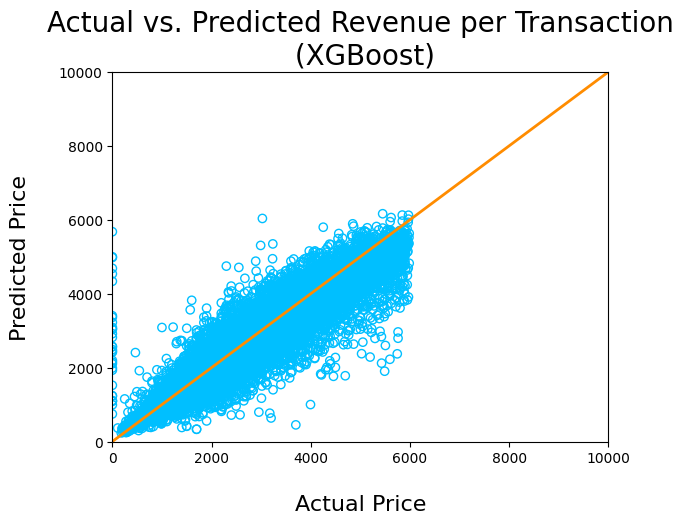

In [29]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n (XGBoost)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### b. Decision Tree Regressor

In [30]:
tuned_parameters_dt = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# GridSearch for Decision Tree
dtr_cv = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=tuned_parameters_dt,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearch on train set
dtr_cv.fit(X_train, y_train)

# Print best params and best R²
print(f"Best hyperparameters (Decision Tree): {dtr_cv.best_params_}\n")
print(f"Best R²: {dtr_cv.best_score_}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best hyperparameters (Decision Tree): {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}

Best R²: 0.7582854464683396


In [31]:
# Decision Tree Regressor with best hyperparameters
dtr_mod = DecisionTreeRegressor(
    random_state=42,
    max_depth=dtr_cv.best_params_["max_depth"],
    min_samples_split=dtr_cv.best_params_["min_samples_split"],
    min_samples_leaf=dtr_cv.best_params_["min_samples_leaf"]
)

# Fit the model
dtr_mod.fit(X_train, y_train)

# Predict on test set
y_pred_dtr = dtr_mod.predict(X_test)

# Print R² and RMSE
print(f"- {dtr_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_dtr)}")
print(f"RMSE: {rmse_score(y_test, y_pred_dtr)}")

- DecisionTreeRegressor
R²: 0.7301113880078336
RMSE: 0.3137215253201429


In [32]:
# Save results
model_list.append(dtr_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_dtr), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_dtr), 4))

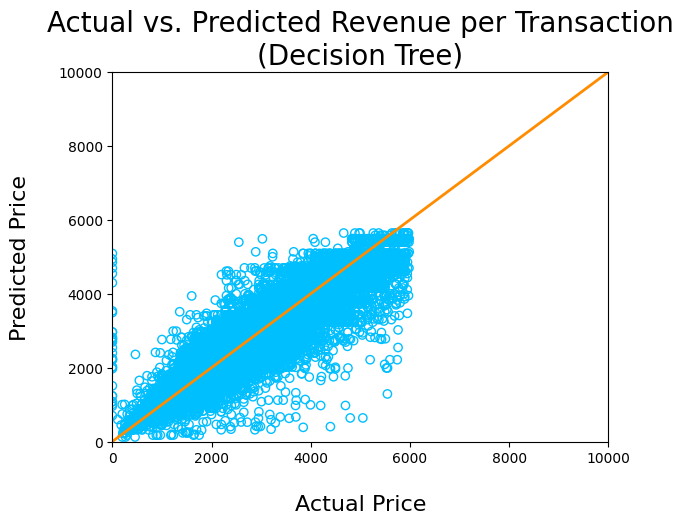

In [33]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_dtr)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Decision Tree)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### c. Huber Regression

In [34]:
from sklearn.linear_model import HuberRegressor
from sklearn.model_selection import GridSearchCV

# Define hyperparameters for HuberRegressor
tuned_parameters_huber = {
    "epsilon": [1.1, 1.35, 1.5],  # controls sensitivity to outliers
    "alpha": [0.0001, 0.001, 0.01]  # regularization term
}

# GridSearch for HuberRegressor
huber_cv = GridSearchCV(
    estimator=HuberRegressor(),
    param_grid=tuned_parameters_huber,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='r2'
)

# Fit GridSearch on train set
huber_cv.fit(X_train, y_train)

# Print best params and best R²
print(f"Best hyperparameters (Huber): {huber_cv.best_params_}\n")
print(f"Best R²: {huber_cv.best_score_}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best hyperparameters (Huber): {'alpha': 0.01, 'epsilon': 1.5}

Best R²: 0.7452797970558838


In [35]:
# Huber Regressor with best hyperparameters
huber_mod = HuberRegressor(
    epsilon=huber_cv.best_params_["epsilon"],
    alpha=huber_cv.best_params_["alpha"]
)

# Fit the model
huber_mod.fit(X_train, y_train)

# Predict on test set
y_pred_huber = huber_mod.predict(X_test)

# Print R² and RMSE
print(f"- {huber_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_huber)}")
print(f"RMSE: {rmse_score(y_test, y_pred_huber)}")

- HuberRegressor
R²: 0.7118329839122194
RMSE: 0.32417100897683193


In [36]:
# Save results
model_list.append(huber_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_huber), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_huber), 4))

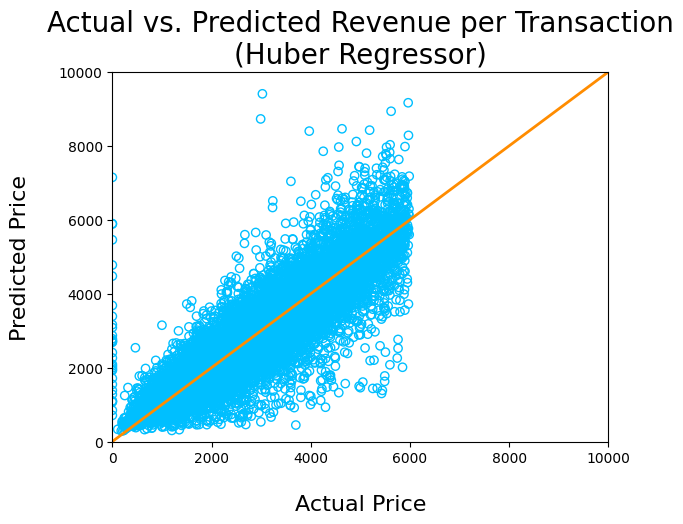

In [37]:
# Plot Actual vs. Predicted Revenue per Transaction
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_huber)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Huber Regressor)", fontsize=20)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=16)
plt.ylabel("Predicted Price\n", fontsize=16)
plt.show()

#### d. Random Forest Regressor

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters versi ringan
param_dist_rf = {
    "n_estimators": [100, 200],        # jumlah pohon cukup 2 opsi
    "max_depth": [10, None],           # batasi kedalaman agar tidak overfit
    "max_features": ["sqrt"],          # gunakan default yang optimal
    "min_samples_split": [2, 5],       # sedikit variasi
}

# RandomizedSearch (lebih cepat daripada GridSearch)
rf_random = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=5,            # hanya 5 kombinasi acak
    cv=3,                # 3-fold cross-validation untuk hemat waktu
    n_jobs=-1,
    verbose=1,
    scoring="r2",
    random_state=42
)

# Fit RandomizedSearch pada data train
rf_random.fit(X_train, y_train)

# Print hasil terbaik
print(f"Best hyperparameters (Random Forest): {rf_random.best_params_}\n")
print(f"Best R²: {rf_random.best_score_}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best hyperparameters (Random Forest): {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'sqrt', 'max_depth': None}

Best R²: 0.7835353985399401


In [39]:
rf_mod = rf_random.best_estimator_

# Prediksi pada test set
y_pred_rf = rf_mod.predict(X_test)

# Evaluasi performa
print(f"- {rf_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_rf)}")
print(f"RMSE: {rmse_score(y_test, y_pred_rf)}")

- RandomForestRegressor
R²: 0.7513667748437631
RMSE: 0.3011144656856174


In [40]:
model_list.append(rf_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_rf), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_rf), 4))

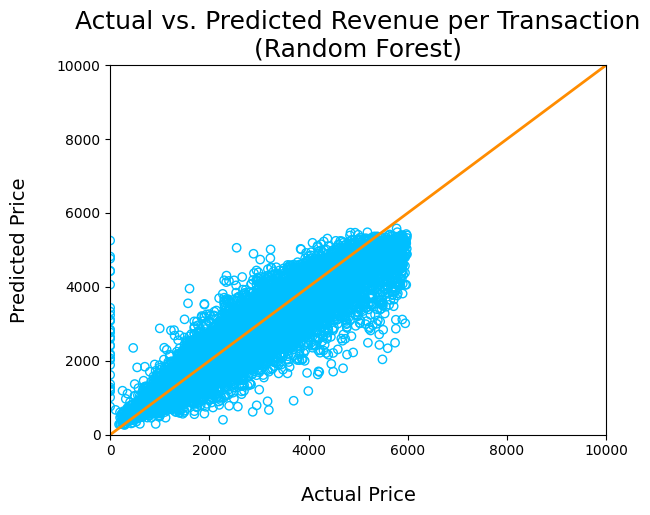

In [41]:
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_rf)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(Random Forest)", fontsize=18)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=14)
plt.ylabel("Predicted Price\n", fontsize=14)
plt.show()

#### e. LightGBM Regressor

In [42]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np

# Define hyperparameters for LightGBM
tuned_parameters_lgb = {
    "num_leaves": [31, 50, 100],         # jumlah daun
    "max_depth": [-1, 10, 20],           # kedalaman pohon (-1 berarti tidak dibatasi)
    "learning_rate": [0.01, 0.05, 0.1],  # kecepatan learning
    "n_estimators": [100, 500]           # jumlah boosting iterations
}

# GridSearchCV
lgb_cv = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=tuned_parameters_lgb,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring="r2"
)

# Fit GridSearch pada data train
lgb_cv.fit(X_train, y_train)

# Print best params dan best R²
print(f"Best hyperparameters (LightGBM): {lgb_cv.best_params_}\n")
print(f"Best R²: {lgb_cv.best_score_}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 120008, number of used features: 51
[LightGBM] [Info] Start training from score 7.576546
Best hyperparameters (LightGBM): {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 50}

Best R²: 0.7899320141027494


In [43]:
lgb_mod = LGBMRegressor(
    random_state=42,
    num_leaves=lgb_cv.best_params_["num_leaves"],
    max_depth=lgb_cv.best_params_["max_depth"],
    learning_rate=lgb_cv.best_params_["learning_rate"],
    n_estimators=lgb_cv.best_params_["n_estimators"]
)

# Fit model
lgb_mod.fit(X_train, y_train)

# Predict pada test set
y_pred_lgb = lgb_mod.predict(X_test)

# Print R² dan RMSE
print(f"- {lgb_mod.__class__.__name__}")
print(f"R²: {rsqr_score(y_test, y_pred_lgb)}")
print(f"RMSE: {rmse_score(y_test, y_pred_lgb)}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1280
[LightGBM] [Info] Number of data points in the train set: 120008, number of used features: 51
[LightGBM] [Info] Start training from score 7.576546
- LGBMRegressor
R²: 0.7565416192882259
RMSE: 0.2979644162837922


In [44]:
model_list.append(lgb_mod.__class__.__name__)
r2_list.append(round(rsqr_score(y_test, y_pred_lgb), 4))
rmse_list.append(round(rmse_score(y_test, y_pred_lgb), 4))

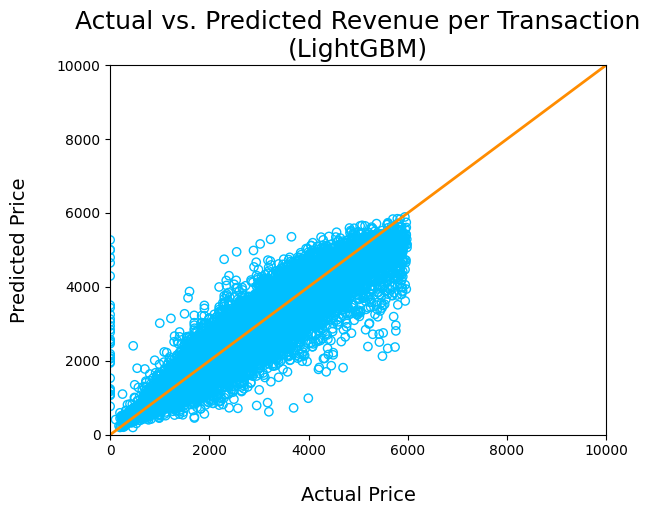

In [45]:
actual_price = np.expm1(y_test["subtotal_log"])
predicted_price = np.expm1(y_pred_lgb)

plt.figure()
plt.title("Actual vs. Predicted Revenue per Transaction\n(LightGBM)", fontsize=18)
plt.scatter(actual_price, predicted_price,
            color="deepskyblue", marker="o", facecolors="none")
plt.plot([0, 10000], [0, 10000], "darkorange", lw=2)
plt.xlim(0, 10000)
plt.ylim(0, 10000)
plt.xlabel("\nActual Price", fontsize=14)
plt.ylabel("Predicted Price\n", fontsize=14)
plt.show()

In [46]:
# Create a table with pd.DataFrame
model_results = pd.DataFrame(
    {
        "Model": model_list,
        "R²": r2_list,
        "RMSE": rmse_list
    }
)

model_results

,Model,R²,RMSE
0,XGBRegressor,0.7543,0.2993
1,DecisionTreeRegressor,0.7301,0.3137
2,HuberRegressor,0.7118,0.3242
3,RandomForestRegressor,0.7514,0.3011
4,LGBMRegressor,0.7565,0.2980
